# Torch sanity checks
> Verifying that the `TorchSolver` class is working as expected.

## Data generation

In [12]:
import sys
sys.path.append('/home/phil/aptr')
# sys.path.append('~/aptr')
# sys.path.append('/Users/phil/Columbia/aPTR')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.torch_solver import TorchSolver
from src.database import RnaDB

from src.solve_table import solve_all, score_predictions
from src.simulation import simulate_from_ids

In [14]:
# Load a database object

db = RnaDB()

/home/phil/miniconda3/envs/aPTR/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/phil/miniconda3/envs/aPTR/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [15]:
# Get 10 complete genomes

genomes = db.db[db.db["n_contigs"] == 1]["genome"].unique()
genomes_to_use = np.random.choice(genomes, 10, replace=False)

# Simulate reads from those genomes
reads, ptrs, coverages, otus = simulate_from_ids(
    db=db.db,
    ids=genomes_to_use,
    fasta_path="/home/phil/aptr/data/seqs",
    n_samples=5,
    scale=1e4,
    shuffle=False,  # Suppress shuffling to conserve memory
    fastq=False
)


Generating sample 0 for organism 595494.3...
Generating sample 0 for organism 471856.5...
Generating sample 0 for organism 632348.3...
Generating sample 0 for organism 486410.3...
Generating sample 0 for organism 732.8...
Generating sample 0 for organism 467200.3...
Generating sample 0 for organism 485918.6...
Generating sample 0 for organism 195103.10...
Generating sample 0 for organism 41514.7...
Generating sample 0 for organism 209261.6...
Sample RNA:
[{'eae3a07b909059cb752ac3435882a64d': 0, 'f7595c5c325ac9ee6c42372895f22fee': 0, '3a48183a655bba37268dee46d09a4844': 0, '3cd7b8b30cb191c4a8292a1943a4dc0a': 0, '08f79fef0ee0751cd29564f37948a7a2': 0, 'fe5decee8dcdc306a69240bce16ea47a': 1, 'a72c43315ab432a5d8231e7708931170': 0}, {'d880dc07f377979f8990abe030615b07': 3, 'bd33bd040081bea8c9038d19746b4a92': 2}, {'3ee356a68cb2ddda9fd978e1c65f4c1d': 1, 'ca1bce50c09b1bb3894b448d4c1803d1': 4, '4c9b5043a3ff31591bad860702f8f657': 6}, {'411922d4c0a99f6c5cb91632b565f4ad': 0, '8e36846affd82ca0049fce0ee

Now let's take a second to look at all of the simulation outputs:

In [16]:
print(reads) # Should be None, since we didn't ask for fastq output

None


In [17]:
print(ptrs) # A #{genomes} x #{samples} matrix of PTRs
# In this case, should be 10x5
print(ptrs.shape)

[[1.13188419 1.55399549 1.38570469 1.71171916 1.07980174]
 [1.07300133 1.67416382 1.50747209 1.77857331 1.87826021]
 [1.68166827 1.12512265 1.72065162 1.23469213 1.58894517]
 [1.24036715 1.72788602 1.39406253 1.95943266 1.64709993]
 [1.37909514 1.58785925 1.09074412 1.92968611 1.563262  ]
 [1.70978835 1.13598478 1.56789473 1.46383489 1.147563  ]
 [1.84214989 1.27308172 1.96223585 1.25943802 1.92292787]
 [1.62061636 1.59323528 1.07704315 1.26693828 1.10039944]
 [1.6474402  1.5638581  1.63576519 1.25563805 1.61191443]
 [1.57093617 1.32467285 1.58851599 1.37100733 1.145372  ]]
(10, 5)


In [18]:
print(coverages)
print(coverages.shape) # Should also be 10x5, positive integers

[[ 1783  2841 25114 22461  9536]
 [ 3559 20063 10801   949 18234]
 [14322  8274  7871  6692 14470]
 [ 3501  6406   101 47580 33993]
 [11481   365  6294  9387 10095]
 [31036   381  7767 15622 81589]
 [35406   153  1699   387 60552]
 [16399  9861 10755  1602  6129]
 [  621  6939  3886  3520 10510]
 [ 8255  6020  3741 30162  6634]]
(10, 5)


In [19]:
print(otus)

                                     0     1    2     3     4
eae3a07b909059cb752ac3435882a64d   0.0   0.0  8.0   6.0   1.0
f7595c5c325ac9ee6c42372895f22fee   0.0   1.0  5.0   5.0   1.0
3a48183a655bba37268dee46d09a4844   0.0   1.0  6.0   4.0   4.0
3cd7b8b30cb191c4a8292a1943a4dc0a   0.0   0.0  6.0   3.0   0.0
08f79fef0ee0751cd29564f37948a7a2   0.0   0.0  3.0   4.0   1.0
fe5decee8dcdc306a69240bce16ea47a   1.0   1.0  3.0   5.0   2.0
a72c43315ab432a5d8231e7708931170   0.0   1.0  0.0   7.0   2.0
d880dc07f377979f8990abe030615b07   3.0  21.0  5.0   1.0  11.0
bd33bd040081bea8c9038d19746b4a92   2.0   6.0  3.0   0.0   7.0
3ee356a68cb2ddda9fd978e1c65f4c1d   1.0   1.0  1.0   1.0   4.0
ca1bce50c09b1bb3894b448d4c1803d1   4.0   1.0  0.0   1.0   4.0
4c9b5043a3ff31591bad860702f8f657   6.0   2.0  3.0   2.0   5.0
411922d4c0a99f6c5cb91632b565f4ad   0.0   2.0  0.0  13.0  13.0
8e36846affd82ca0049fce0ee0d5abfb   1.0   4.0  0.0  29.0  24.0
62f226e73cce6b14fdead682bb1a910c   0.0   1.0  0.0  11.0  15.0
a42dcb24

## Torch checks

Remember, the TorchSolver object assumes you have a 'genomes' dict which has the keys:
* seqs -> indices for which sequence the genome has
* pos -> start position for RNA gene

In [20]:
solver_genomes, md5s = db.generate_genome_objects(genomes_to_use)
print(solver_genomes)
print(len(solver_genomes)) # Should be 10, since there are 10 genomes

[{'id': '595494.3', 'pos': array([0.10530488, 0.05920821, 0.00759083, 0.12430761, 0.06226068,
       0.15211656, 0.04864241, 0.26222772]), 'seqs': [0, 1, 2, 3, 0, 4, 5, 6]}, {'id': '471856.5', 'pos': array([0.43391367, 0.32470689, 0.0608642 , 0.12741277, 0.26224103]), 'seqs': [7, 7, 7, 8, 8]}, {'id': '632348.3', 'pos': array([0.41144601, 0.13902985, 0.13981999]), 'seqs': [9, 10, 11]}, {'id': '486410.3', 'pos': array([0.13402917, 0.1596708 , 0.00917895, 0.23540454, 0.03833142]), 'seqs': [12, 13, 14, 13, 15]}, {'id': '732.8', 'pos': array([0.1252964 , 0.18511431, 0.42031049, 0.22922043, 0.27884007,
       0.20683748]), 'seqs': [16, 17, 18, 17, 19, 20]}, {'id': '467200.3', 'pos': array([0.0952299 , 0.26983866, 0.0651033 , 0.2403129 , 0.06526448,
       0.33733675, 0.02922838, 0.33717943, 0.26996255]), 'seqs': [21, 22, 23, 24, 25, 26, 27, 28, 29]}, {'id': '485918.6', 'pos': array([0.18626661, 0.18745809, 0.18843416, 0.18926726, 0.18686657,
       0.18905658]), 'seqs': [30, 31, 32, 31, 33, 

In [21]:
# Here we initialize a TorchSolver with the genomes and coverages from before

solver = TorchSolver(
    genomes=solver_genomes,
    coverages=otus[0]
)

In [22]:
# Check that a_hat updates 

print(solver.a_hat)
solver.train()
print(solver.a_hat)

tensor([0.5167, 0.3571, 0.3184, 0.6938, 0.0614, 0.2638, 0.6878, 0.4754, 0.2732,
        0.0679], requires_grad=True)
tensor([0.5167, 0.3571, 0.3184, 0.6938, 0.0614, 0.2638, 0.6878, 0.4754, 0.2732,
        0.0679], requires_grad=True)


In [23]:
# Let's try to write out the torch model here
import torch

# Learnable parameters are a_hat and b_hat
a_hat = torch.rand(10, dtype=torch.float32)
b_hat = torch.log(1 + torch.rand(10, dtype=torch.float32)) # log-PTR

# Let's just make copies of the existing C, D, E matrices
C = torch.tensor(solver.members, dtype=torch.float32)
D = torch.tensor(solver.dists, dtype=torch.float32)
E = torch.tensor(solver.gene_to_seq, dtype=torch.float32)
f_true = torch.tensor(otus[0], dtype=torch.float32)

# Some counts from the model
n = solver.n
m = solver.m
k = solver.k

# LR hyperparameter
lr = 1e-3

for i in range(10000):
    # Forward pass
    g = a_hat @ C + 1 - b_hat @ D
    f = torch.exp(g) @ E

    # Loss
    loss = torch.sum((f - f_true)**2)
    print(loss)

    # Gradients
    dL_df = f - f_true
    dL_dg = (2 / k) * torch.exp(g) * (E @ dL_df)
    dL_da = C @ dL_dg
    dL_db = -D @ dL_dg

    # Update parameters
    a_hat = a_hat - lr * dL_da
    b_hat = b_hat - lr * dL_db


/home/phil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/home/phil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/phil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


tensor(926.3041)
tensor(910.0994)
tensor(894.4673)
tensor(879.3779)
tensor(864.8036)
tensor(850.7183)
tensor(837.0980)
tensor(823.9200)
tensor(811.1630)
tensor(798.8073)
tensor(786.8343)
tensor(775.2263)
tensor(763.9675)
tensor(753.0420)
tensor(742.4352)
tensor(732.1335)
tensor(722.1243)
tensor(712.3951)
tensor(702.9344)
tensor(693.7314)
tensor(684.7756)
tensor(676.0573)
tensor(667.5673)
tensor(659.2969)
tensor(651.2375)
tensor(643.3814)
tensor(635.7210)
tensor(628.2492)
tensor(620.9592)
tensor(613.8444)
tensor(606.8987)
tensor(600.1160)
tensor(593.4910)
tensor(587.0181)
tensor(580.6923)
tensor(574.5087)
tensor(568.4625)
tensor(562.5493)
tensor(556.7648)
tensor(551.1049)
tensor(545.5657)
tensor(540.1434)
tensor(534.8344)
tensor(529.6351)
tensor(524.5425)
tensor(519.5530)
tensor(514.6639)
tensor(509.8720)
tensor(505.1745)
tensor(500.5688)
tensor(496.0523)
tensor(491.6223)
tensor(487.2765)
tensor(483.0125)
tensor(478.8282)
tensor(474.7211)
tensor(470.6895)
tensor(466.7311)
tensor(462.844

In [24]:
# The same model, but using Adam:

# Learnable parameters are a_hat and b_hat
a_hat = torch.rand(10, dtype=torch.float32, requires_grad=True)
b_hat = torch.rand(10, dtype=torch.float32, requires_grad=True) # log-PTR
b = torch.log(1 + b_hat) # log-PTR

# Let's just make copies of the existing C, D, E matrices
C = torch.tensor(solver.members, dtype=torch.float32)
D = torch.tensor(solver.dists, dtype=torch.float32)
E = torch.tensor(solver.gene_to_seq, dtype=torch.float32)
f_true = torch.tensor(otus[0], dtype=torch.float32)

# Some counts from the model
n = solver.n
m = solver.m
k = solver.k

# LR hyperparameter
lr = 1e-3

# Optimizer
optimizer = torch.optim.Adam([a_hat, b_hat], lr=lr)

for i in range(10000):
    # Forward pass
    g = a_hat @ C + 1 - b @ D
    f = torch.exp(g) @ E

    # Loss: use torch built-in
    loss = torch.nn.functional.mse_loss(f, f_true)
    print(loss)

    # Update parameters
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()

/home/phil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/home/phil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/phil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


tensor(29.9785, grad_fn=<MseLossBackward0>)
tensor(29.9078, grad_fn=<MseLossBackward0>)
tensor(29.8374, grad_fn=<MseLossBackward0>)
tensor(29.7671, grad_fn=<MseLossBackward0>)
tensor(29.6970, grad_fn=<MseLossBackward0>)
tensor(29.6270, grad_fn=<MseLossBackward0>)
tensor(29.5573, grad_fn=<MseLossBackward0>)
tensor(29.4877, grad_fn=<MseLossBackward0>)
tensor(29.4183, grad_fn=<MseLossBackward0>)
tensor(29.3491, grad_fn=<MseLossBackward0>)
tensor(29.2801, grad_fn=<MseLossBackward0>)
tensor(29.2112, grad_fn=<MseLossBackward0>)
tensor(29.1426, grad_fn=<MseLossBackward0>)
tensor(29.0741, grad_fn=<MseLossBackward0>)
tensor(29.0058, grad_fn=<MseLossBackward0>)
tensor(28.9378, grad_fn=<MseLossBackward0>)
tensor(28.8699, grad_fn=<MseLossBackward0>)
tensor(28.8022, grad_fn=<MseLossBackward0>)
tensor(28.7347, grad_fn=<MseLossBackward0>)
tensor(28.6675, grad_fn=<MseLossBackward0>)
tensor(28.6004, grad_fn=<MseLossBackward0>)
tensor(28.5335, grad_fn=<MseLossBackward0>)
tensor(28.4669, grad_fn=<MseLoss

In [26]:
# The same model, but using epochs:

# Global parameters
N_EPOCHS = 10000
LR = 1e-3
ITERATIONS_PER_EPOCH = 1000

# Learnable parameters are a_hat and b_hat
a_hat = torch.rand(10, dtype=torch.float32, requires_grad=True)
b_hat = torch.rand(10, dtype=torch.float32, requires_grad=True) # log-PTR
b = torch.log(1 + b_hat) # log-PTR

# Let's just make copies of the existing C, D, E matrices
C = torch.tensor(solver.members, dtype=torch.float32)
D = torch.tensor(solver.dists, dtype=torch.float32)
E = torch.tensor(solver.gene_to_seq, dtype=torch.float32)
f_true = torch.tensor(otus[0], dtype=torch.float32)

# Some counts from the model
n = solver.n
m = solver.m
k = solver.k

# LR hyperparameter
lr = 1e-3

# Optimizer
optimizer = torch.optim.Adam([a_hat, b_hat], lr=lr)

for epoch in range(N_EPOCHS):
    for iter in range(ITERATIONS_PER_EPOCH):
        # Forward pass
        g = a_hat @ C + 1 - b @ D
        f = torch.exp(g) @ E

        # Loss: use torch built-in
        loss = torch.nn.functional.mse_loss(f, f_true)

        # Update parameters
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    print(loss)

/home/phil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/phil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/home/phil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


tensor(3.2721, grad_fn=<MseLossBackward0>)
tensor(1.9859, grad_fn=<MseLossBackward0>)
tensor(1.6634, grad_fn=<MseLossBackward0>)
tensor(1.5613, grad_fn=<MseLossBackward0>)
tensor(1.5242, grad_fn=<MseLossBackward0>)
tensor(1.5089, grad_fn=<MseLossBackward0>)
tensor(1.5019, grad_fn=<MseLossBackward0>)
tensor(1.4984, grad_fn=<MseLossBackward0>)
tensor(1.4966, grad_fn=<MseLossBackward0>)
tensor(1.4956, grad_fn=<MseLossBackward0>)
tensor(1.4951, grad_fn=<MseLossBackward0>)
tensor(1.4949, grad_fn=<MseLossBackward0>)
tensor(1.4948, grad_fn=<MseLossBackward0>)
tensor(1.4948, grad_fn=<MseLossBackward0>)
tensor(1.4948, grad_fn=<MseLossBackward0>)
tensor(1.4948, grad_fn=<MseLossBackward0>)
tensor(1.4948, grad_fn=<MseLossBackward0>)
tensor(1.4948, grad_fn=<MseLossBackward0>)
tensor(1.4948, grad_fn=<MseLossBackward0>)
tensor(1.4948, grad_fn=<MseLossBackward0>)
tensor(1.4948, grad_fn=<MseLossBackward0>)
tensor(1.4948, grad_fn=<MseLossBackward0>)
tensor(1.4948, grad_fn=<MseLossBackward0>)
tensor(1.49

KeyboardInterrupt: 

In [ ]:
solver = TorchSolver(genomes=solver_genomes, coverages=otus[0])

optimizer = torch.optim.Adam([solver.a_hat, solver.b_hat], lr=1e-4)

for epoch in range(N_EPOCHS):
    for iter in range(ITERATIONS_PER_EPOCH):
        # Forward pass
        f = solver()

        # Loss: use torch built-in
        loss = torch.nn.functional.mse_loss(f, f_true)

        # Update parameters
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    print(loss)

tensor(54.2684, grad_fn=<MseLossBackward0>)
tensor(42.5340, grad_fn=<MseLossBackward0>)
tensor(33.7842, grad_fn=<MseLossBackward0>)
tensor(26.9954, grad_fn=<MseLossBackward0>)
tensor(21.6117, grad_fn=<MseLossBackward0>)
tensor(17.3093, grad_fn=<MseLossBackward0>)
tensor(13.8624, grad_fn=<MseLossBackward0>)
tensor(11.1064, grad_fn=<MseLossBackward0>)
tensor(8.9153, grad_fn=<MseLossBackward0>)
tensor(7.1880, grad_fn=<MseLossBackward0>)
tensor(5.8355, grad_fn=<MseLossBackward0>)
tensor(4.7770, grad_fn=<MseLossBackward0>)
tensor(3.9486, grad_fn=<MseLossBackward0>)
tensor(3.3029, grad_fn=<MseLossBackward0>)
tensor(2.8035, grad_fn=<MseLossBackward0>)
tensor(2.4214, grad_fn=<MseLossBackward0>)
tensor(2.1331, grad_fn=<MseLossBackward0>)
tensor(1.9189, grad_fn=<MseLossBackward0>)
tensor(1.7620, grad_fn=<MseLossBackward0>)
tensor(1.6478, grad_fn=<MseLossBackward0>)
tensor(1.5633, grad_fn=<MseLossBackward0>)
tensor(1.4974, grad_fn=<MseLossBackward0>)
tensor(1.4418, grad_fn=<MseLossBackward0>)
ten

In [ ]:
solver.b_hat.shape

torch.Size([54])

In [ ]:
solver.members

tensor([[1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0.,

Epoch 0:	 1.1837894916534424
Epoch 1:	 1.181800127029419
Epoch 2:	 1.1807221174240112
Epoch 3:	 1.1796441078186035
Epoch 4:	 1.1788344383239746
Epoch 5:	 1.1781362295150757
Epoch 6:	 1.1779453754425049
Epoch 7:	 1.1772066354751587
Epoch 8:	 1.1768743991851807
Epoch 9:	 1.176493525505066
Epoch 10:	 1.1763427257537842
Epoch 11:	 1.1760485172271729
Epoch 12:	 1.1760808229446411
Epoch 13:	 1.1757404804229736
Epoch 14:	 1.1756194829940796
Epoch 15:	 1.1755198240280151
Epoch 16:	 1.1756881475448608


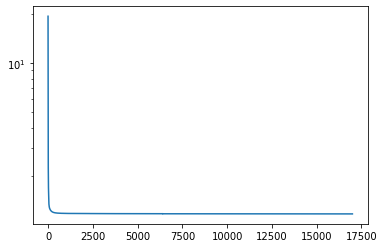

In [46]:
# Check that solver.train() works

a, b, losses = solver.train(tolerance=0)

plt.plot(losses)
plt.yscale("log")

In [48]:
plt.matshow(np.exp(a))

tensor([9.4663e-02, 3.6788e-01, 4.1613e+00, 6.5914e-01, 1.3967e+00, 1.1770e+00,
        6.7639e-07, 1.2505e+00, 1.5472e-01, 9.9832e-01])

In [52]:
coverages[:,0]

array([ 1783,  3559, 14322,  3501, 11481, 31036, 35406, 16399,   621,
        8255])